# word2vec Concept Dependency Graph
In this notebook, we are trying to use word2vec embeddings that were trained on the corpus of textbooks to identify dependencies and disambiguate the concepts independent of Wikipedia.

In [1]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords
from matplotlib import pyplot as plt
import os
import numpy as np

In [2]:
data = pd.read_json("C:/Users/anast/Documents/EDU/PROJECT -learning dependencies/dat/parsed_books/parsed_books.json")
texts=""
for book in data.pages:
    texts+="".join(book)

In [3]:
path = "../dat/index/"
concepts = set()
indices = {}

def get_smallest_page(pages):
    if not isinstance(pages, int) and "nan" in pages: return None
    pages_int = [pages] if isinstance(pages, int) else list(map(int, pages.split(",")))
    return min(pages_int)

for book in os.listdir(path):
    index = pd.read_csv(path + book).dropna()
    index['first_page'] = index.pages.apply(get_smallest_page) # add first page of index entry
    index['concept'] = index['concept'].str.lower()
    index['concept'] =  index['concept'].replace("�","s")

    index = index.loc[index.level ==1] # only 1st level
    
    index['concept'] = [i[:-1] if i[-1]==" " else i for i in index['concept']]
    index['concept'] = index["concept"].apply(lambda c: "_".join(c.split()))
    indices[book] = index
    concepts.update(index.concept)

#for book in os.listdir(path):
#    index = pd.read_csv(path + book).dropna()
    #index.concept = index.concept.apply(lambda x: x.encode("ascii", "ignore"))
#    indices[book] = index
#    concepts.update(index.concept) # add new concepts to set

#concepts_list = [i.lower() for i in list(concepts)]
#n = len(concepts)
print(str(len(concepts)) + " concepts in total")

2004 concepts in total


In [4]:
#concepts_list =[i.replace("�","s") for i in concepts_list if ',' not in i] # remove the subconcepts
#concepts_list = [i[:-1] if i[-1]==" " else i for i in concepts_list ]
concepts_list = sorted(concepts, key = len)[::-1]
concepts_list[:20]

['symmetric_linear_operator_on_ﬁnite_dimensional_inner_product_space',
 'introduction_to_the_theory_of_error-correcting_codes_(pless)',
 'square_matrix_(n_×_n_matrix)_characteristic_polynomial',
 'matrix_of_t_corresponding_to_the_ordered_bases_b_and_d',
 'eigenvalue_and_eigenvector_of_a_linear_transformation',
 '“linear_programming_and_extensions”_(wu_and_coppins)',
 'trivial_solution_to_homogeneous_systems_of_equations',
 'homogeneous_equations_associated_homogeneous_system',
 ',_nonconstant_polynomial_with_complex_coefﬁcients',
 'matrix_of_composite_of_two_linear_transformations',
 'characteristic_polynomial_block_triangular_matrix',
 'relation_of_linear_dependence_for_column_vectors',
 'cayley–hamilton_theorem_on_complex_vector_space',
 'invertible_matrix_and_invertible_transformation',
 'introduction_to_matrix_computations_(stewart)',
 'introduction_to_abstract_algebra_(nicholson)',
 'solution_set_of_a_system_of_linear_equations',
 'summation_notation_for_permutation_expansion',
 '

In [5]:
texts = texts.lower()
concepts_in_text = []

for concept in concepts_list:
    texts = texts.replace(concept.replace("_"," "), concept)
    if concept in texts:
        concepts_in_text.append(concept)
        
texts = remove_stopwords(texts)
texts[:1000]

'chapter sle systems linear_equations motivate study linear_algebra studying solutions systems linear_equations. focus chapter practical matter find, describe, solutions, setting theoretical ideas appear later. section wila linear_algebra? begin study linear_algebra introduction motivational example. subsection linear_algebra subject linear_algebra partially explained meaning terms comprising title. linear term appreciate better end course, indeed, attaining appreciation taken primary goals course. now, understand mean straight flat. example xy-plane accustomed describing straight lines (is kind?) set solutions equation form slope y-intercept constants line. studied multivariate calculus, encountered planes. living dimensions, coordinates described triples (x, z), described set solutions equations form constants determine plane. planes flat, lines dimensions described straight. multivariate calculus course recall lines sets points described equationswila beezer: course linear_algebra p

In [6]:
len(concepts_in_text)

1633

In [7]:
from collections import Counter
freqs=Counter(texts.split(" "))
words_descending=[key for key, value in freqs.most_common()]
concepts_sorted_by_freq = [word for word in words_descending if word in concepts_in_text]

In [8]:
tokenized_sentences = [list(tokenize(sentence)) for sentence in texts.split(". ")]

vector_size=30
model = Word2Vec(sentences=tokenized_sentences, vector_size=vector_size, window=20, min_count=5, 
            workers=4,seed=123,sg=0) #sg=1 skip-gram, sg=0 cbow

In [9]:
len(model.wv.index_to_key)

6303

In [10]:
model.wv.most_similar(positive=['linear_equations'], topn=10) 

[('systems', 0.9476954340934753),
 ('solution_sets', 0.8855022192001343),
 ('procedures', 0.8810798525810242),
 ('sle', 0.8608858585357666),
 ('equations', 0.8462526798248291),
 ('system_of_linear_equations', 0.84596186876297),
 ('linear_systems', 0.8293059468269348),
 ('elementary_operations', 0.8279643058776855),
 ('unknowns', 0.8125085830688477),
 ('general_solution', 0.8053034543991089)]

In [11]:
model.wv.most_similar(positive=['eigenvalue'], topn=10) 

[('eigenvector', 0.8825623393058777),
 ('algebraic_multiplicity', 0.8582472205162048),
 ('eem', 0.8524372577667236),
 ('eigenspace', 0.8343952894210815),
 ('geometric_multiplicity', 0.8209526538848877),
 ('associated', 0.8132345676422119),
 ('algebraic_multiplicity_of_an_eigenvalue', 0.8098049163818359),
 ('eigenvalues', 0.7813721299171448),
 ('eigenvectors', 0.7804003953933716),
 ('basic_eigenvectors', 0.7730729579925537)]

In [12]:
print(model.wv.doesnt_match(['linear_equations', 'determinant', 'systems', 'nonlinear']))

determinant


In [13]:
model.wv.most_similar(positive=['determinant'], topn=10) 

[('determinant_of_a_matrix', 0.9140462875366211),
 ('determinants', 0.8878790140151978),
 ('laplace_expansion', 0.8640825152397156),
 ('cofactors', 0.8564496040344238),
 ('expanding', 0.8467309474945068),
 ('cofactor_expansion', 0.8446972370147705),
 ('expansion', 0.8410966396331787),
 ('minors', 0.8403536081314087),
 ('det', 0.8095355033874512),
 ('cofactor_expansion_theorem', 0.796820342540741)]

In [14]:
embeddings = np.zeros((len(concepts_sorted_by_freq),vector_size))
not_in_vocab = []

for i,concept in enumerate(concepts_sorted_by_freq):
    try:
        embeddings[i,:]+= model.wv[concept]
    except:
        not_in_vocab.append(concept)
print("Not in model vocab: ", len(not_in_vocab))
non_zero_idx = np.where(embeddings.any(axis=1))[0]

embeddings = embeddings[non_zero_idx,:]
concepts = np.array(concepts_sorted_by_freq)[non_zero_idx]

Not in model vocab:  427


In [15]:
#X_emb = TSNE(n_components=2, learning_rate='auto',
#                  init='random', perplexity=500).fit_transform(embeddings[non_zero_idx,:])
#tsne_output=pd.DataFrame({"concept":np.array(concepts_in_text)[non_zero_idx],"x":X_emb[:,0],"y":X_emb[:,1]})
#tsne_output.to_excel("../dat/tsne_emb.xlsx")

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

sim_threshold = 0.95

similarity_matrix = cosine_similarity(embeddings)
np.fill_diagonal(similarity_matrix,0)
synonyms_idx = np.where(similarity_matrix>=sim_threshold)

synonyms_df = pd.DataFrame({"concept":concepts[synonyms_idx[0]], "synonyms":concepts[synonyms_idx[1]]})
synonyms_df["synonyms"] = (
                synonyms_df.groupby('concept')['synonyms']
                .transform(lambda x: ','.join(x))
                )
synonyms_df = synonyms_df.drop_duplicates()

In [17]:
synonyms_df.to_excel("../dat/synonyms_emb.xlsx",index=False)

In [18]:
dict_of_synonyms = {}
for key, value in zip(synonyms_idx[0],synonyms_idx[1]):
    if key in dict_of_synonyms.keys():
        dict_of_synonyms[key]=np.append(dict_of_synonyms[key],value)
    else:
        dict_of_synonyms[key] = np.array([value])

In [19]:
concepts_disamb = []
concepts = np.array(concepts)
used = set()

for i in range(len(concepts)):
    if i in used:
        continue
    concept = concepts[i]

    if i in dict_of_synonyms.keys():

        synonyms = concepts[dict_of_synonyms[i]]
        concept = [concept] + list(synonyms)
        concepts_disamb.append(concept)
        used.update(dict_of_synonyms[i])
    else:
        concepts_disamb.append(concept)


In [20]:
similarities_disamb = np.delete(similarity_matrix,list(used),axis=1)
similarities_disamb = np.delete(similarities_disamb,list(used),axis=0)
similarities_disamb.shape

(985, 985)

In [21]:
concepts_disamb

['matrix',
 'example',
 'theorem',
 'vector',
 'set',
 'equation',
 'basis',
 'vectors',
 'solution',
 'row',
 'function',
 'matrices',
 'point',
 'subspace',
 'line',
 'vector_space',
 'column',
 'eigenvalues',
 'equal',
 'sum',
 'determinant',
 'span',
 'solutions',
 'polynomial',
 'linear_transformation',
 'formula',
 'inverse',
 'linear_combination',
 'dimension',
 'linearly_independent',
 'plane',
 'linear_algebra',
 'eigenvalue',
 'notice',
 'space',
 'eigenvectors',
 'range',
 'of_vectors',
 'positive',
 'domain',
 'rank',
 ['input', 'output'],
 'term',
 'degree',
 'invertible',
 'entry',
 'bases',
 'field',
 'distance',
 'factor',
 'operator',
 'transformation',
 'unique',
 'similar',
 'linear',
 'polynomials',
 'linear_operator',
 'lemma',
 'sequence',
 'augmented_matrix',
 'list',
 'implies',
 'scalars',
 'orthogonal',
 'subset',
 'eigenvector',
 'subspaces',
 'characteristic_polynomial',
 'null_space',
 'diagonal',
 ['lines', 'planes'],
 'scalar',
 ['properties_of', 'propert

In [22]:
len(concepts_disamb)

985

## Building an adjacency matrix

In [23]:
indices['Hefferon_LinAlgebra.csv']

,Unnamed: 0,concept,pages,level,first_page
0,0.0,best_ﬁt_line,296,1,296
1,1.0,block_matrix,345,1,345
2,2.0,box,355,1,355
9,8.0,adding_rows,5,1,5
10,9.0,addition_of_vectors,"17,38,84",1,17
...,...,...,...,...,...
633,569.0,zero_division,261,1,261
634,570.0,zero_divisor,243,1,243
635,571.0,zero_homomorphism,192,1,192
636,572.0,zero_matrix,234,1,234


In [24]:
# create 3D array with concept pair in the first two dimensions and book in the third dimension
from itertools import product

n = len(concepts_disamb)
adj = np.tile(np.nan, (n,n,len(indices.keys())))

def get_first_page_for_concept(concept):
    if isinstance(concept,list):
        vals = []
        for word in concept:
            val = index.loc[index.concept == word,"first_page"].values
            if len(val):
                vals.append(min(val)) 
        return min(vals) if len(vals) else None

    else:
        vals = index.loc[index.concept==concept,"first_page"].values
        return vals[0] if len(vals) else None

for idx, index in enumerate(indices.values()):

    first_pages = list(map(get_first_page_for_concept, concepts_disamb))
    combinations = product(first_pages, first_pages)
    comparisons = [
        1 * (page1 < page2) if page1 is not None and page2 is not None
        else None
        for (page1, page2) in combinations
    ]
    comparisons_2d = np.array(comparisons).reshape((n,n))
    np.fill_diagonal(comparisons_2d, None)
    adj[:,:,idx] = comparisons_2d

mean_adj = np.nanmean(adj,axis=2)

C:\Users\anast\AppData\Local\Temp\ipykernel_20080\2207043988.py:33: RuntimeWarning: Mean of empty slice
  mean_adj = np.nanmean(adj,axis=2)


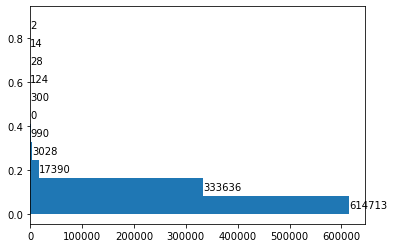

In [25]:
adj_info = np.invert(np.isnan(adj)).mean(axis=2)
counts, edges, bars = plt.hist(adj_info.ravel(),bins=11, orientation="horizontal")
plt.bar_label(bars)
plt.show()

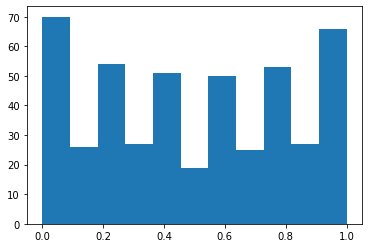

In [26]:
# let's only look at the comparisons where we have at least 5 books with both pairs in it
plt.hist(mean_adj[np.where(adj_info>=0.5)], bins=11)
plt.show()

In [27]:
idx = np.where(adj_info > .5)
np_emb = np.array([",".join(i) if isinstance(i,list) else i for i in concepts_disamb])

# print clear dependencies
np.array(list(zip(np_emb[idx[0]], np_emb[idx[1]], np.round(mean_adj[idx],1))))[np.where(mean_adj[idx]>.9)]

array([['matrix', 'rank', '1.0'],
       ['basis', 'rank', '1.0'],
       ['basis', 'similar_matrices', '1.0'],
       ['vector_space', 'subspace', '1.0'],
       ['span', 'linearly_independent', '1.0'],
       ['span', 'linearly_dependent', '1.0'],
       ['linear_combination', 'basis', '1.0'],
       ['linear_combination', 'dimension', '1.0'],
       ['linear_combination', 'linearly_independent', '1.0'],
       ['linear_combination', 'linearly_dependent', '1.0'],
       ['linear_combination', 'similar_matrices', '1.0'],
       ['dimension', 'rank', '1.0'],
       ['dimension', 'similar_matrices', '1.0'],
       ['row_operations,elementary_row_operations', 'basis', '1.0'],
       ['row_operations,elementary_row_operations', 'dimension', '1.0']],
      dtype='<U40')

In [66]:
n_books_thr=0.5
confidence = 0.7
sim_thr = 0.4

idx = np.where((adj_info >= n_books_thr) & (np.abs(similarities_disamb) >= sim_thr )) # ABSOLUTE VALUE OF COSINE SIM!!!!!!
np_emb = np.array([",".join(i) if isinstance(i,list) else i for i in concepts_disamb])

edges = pd.DataFrame(columns = ["source","target","confidence"])

i=0
for  source, target, conf in zip(np_emb[idx[0]], np_emb[idx[1]], np.round(mean_adj[idx],1)):
    edges.loc[i,:] = [source, target, conf]
    i+=1
edges = edges.loc[edges.confidence >=confidence]

In [29]:
edges.to_excel("..\dat\edges_inds.xlsx")

In [67]:
nodes = list(edges.source.unique()) + list(edges.target.unique())
nodes = set(nodes)
with open("../dat/nodes.txt", "w") as f:
    for node in nodes:
        f.write(node)
        f.write('\n')